In [1]:
from theta.rtbm import RTBM
import numpy as np
import matplotlib.pyplot as plt
from theta.minimizer import CMA, SGD
from theta import costfunctions
%matplotlib inline

In [2]:
ndim = 4
nhid = 1
rtbm = RTBM(ndim, nhid, 
            minimization_bound=55, 
            positive_T=True, 
            positive_Q=True,
            gaussian_init=True           )

def espacio(sample, n=1e5):
    n = int(n)
    u = np.max(sample)
    l = np.min(sample)
    epsilon = np.abs(u)/4.0
    u += epsilon
    l -= epsilon
    r = np.random.rand(ndim, n)
    return l + r*(u-l), pow(u-l, ndim)/n

In [3]:
# Check that the integral integrates correctly
if False:
    nevt = int(1e6)
    ff = lambda x: np.prod(np.sin(x*np.pi*2)**2, axis=0)
    def scale_01(x):
        xmax = np.max(x, axis=0)
        xmin = np.min(x, axis=0)
        return (x - xmin)/(xmax-xmin)

    print("- > Checking the RTBM for sanity")
    r, _ = rtbm.make_sample(nevt)
    rmean = np.mean(r, axis=0)
    rstd = np.std(r, axis=0)
    rmax = rmean + 5.0*rstd
    rmin = rmean - 5.0*rstd
    delta = rmax-rmin
    new_r = np.random.rand(ndim, nevt)*delta.reshape(ndim,1) + rmin.reshape(ndim, 1)
    px = rtbm(new_r)/nevt
    
    print(f"sum: {np.sum(px)}")
    print(f"N/V: {1/np.prod(delta)}")
    print(f"Integral=1: {np.prod(delta)*np.sum(px)}")
    
    def g(z):
        x = (z-rmin.reshape(ndim,1))/(rmax-rmin).reshape(ndim,1)
        return ff(x)

    print("- > Checking the actual result of the integral")
    random_uniform = np.stack([np.random.uniform(rmin[i], rmax[i], size=nevt) for i in range(ndim)], axis=0)
    res_true = ff(np.random.rand(ndim, nevt))/nevt
    res = g(random_uniform)/nevt
    print(f"Integral true result: {np.sum(res_true)}")
    print(f"Integral rescaled_result: {np.sum(res)}")
    
    print("- > Integrating with the simple RTBM g(z)")
    #r,  _ = rtbm.make_sample(nevt)
    prob_x = rtbm(r.T)[0]
    resbm = g(r.T)/nevt/prob_x/np.prod(delta)
    print(f"RTBM integral: {np.sum(resbm)}")
    
    print("- > Asking the RTBM for the probability and x between 0 and 1")
    # Now do everything from the RTBM
    rtbm_x, rho_x, r_raw = rtbm.make_sample_rho(nevt)
    res = ff(rtbm_x.T)/nevt/rho_x
    print(f"RTBM sample integral: {np.sum(res)}")

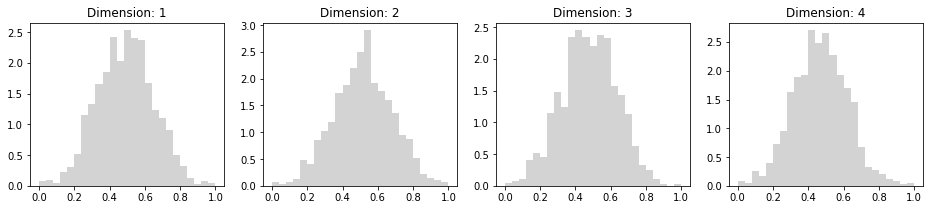

In [4]:
plt.rcParams['figure.figsize'] = [16, 3]

def do_rescale(xrand, y):
    max_per_d = np.max(xrand, axis=0)
    min_per_d = np.min(xrand, axis=0)
    delta = max_per_d - min_per_d
    new_rand = (xrand-min_per_d)/delta
    new_y = y*np.prod(delta)
    return new_rand, new_y

def dome(nevt=1e3, do_rho=True, rescale=True):
    # Sample after gaussian initialization
    nevt = int(nevt)
    xrand, _ = rtbm.make_sample(nevt)
    jac = rtbm(xrand.T)[0]
    
    if rescale:
        xrand, jac = do_rescale(xrand, jac)
    
    for d in range(ndim):
        plt.subplot(1,ndim,d+1)
        plt.title(f"Dimension: {d+1}")
        if do_rho:
            x = sorted(xrand[:,d])
            y = [i for _, i in sorted(zip(xrand[:,d], jac))]
            plt.plot(x, y, color="blue", label=f"p(x_{d+1})", alpha=0.5)
        plt.hist(xrand[:, d], bins=25, density=True, color="lightgray", label="Sample")
    plt.show()
    return xrand
xrand = dome(do_rho=False)

In [5]:
xrand.shape

(1000, 4)

In [6]:
r, jac = espacio(xrand, n=1e5)
aa = rtbm(r)
print(np.sum(aa)*jac)

0.02121704858289291


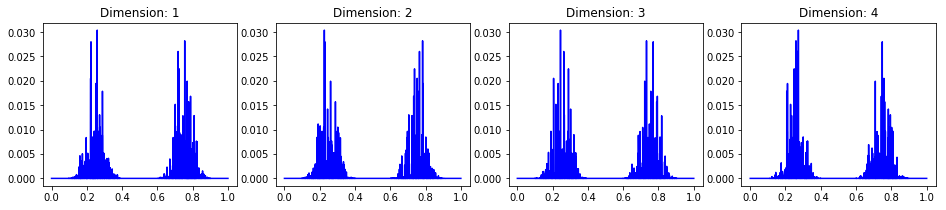

Current mse: 2.1413346697728987e-05
Current KL: 5.3755206959857915


In [7]:
# Now train the RTBM to a _different_ functional form
from scipy.special import expit
n = int(1e4)
ff = lambda x: np.prod(np.sin(x*np.pi*2)**12, axis=1)
xvals = np.random.rand(n, ndim)
yvals_raw = ff(xvals)
yvals = yvals_raw/np.sum(yvals_raw)
for d in range(ndim):
    plt.subplot(1,ndim,d+1)
    plt.title(f"Dimension: {d+1}")
    x = sorted(xvals[:,d])
    y = [i for _, i in sorted(zip(xvals[:,d], yvals))]
    plt.plot(x, y, color="blue", label=f"p(x_{d+1})")
    #plt.hist(xrand[:, d], bins=25, density=True, color="lightgray", label="Sample")
plt.show()

current_val = rtbm(xvals.T)[0]
print(f"Current mse: {costfunctions.mse.cost(current_val, yvals)}")
print(f"Current KL: {costfunctions.kullbackLeibler.cost(current_val, yvals)}")

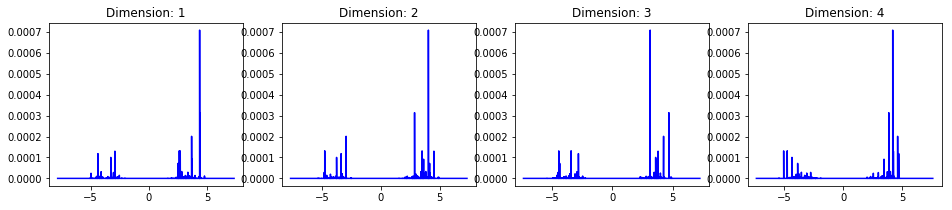


The plots look bad, because we are generating a lot of points in the middle
where the function is 0. The RTBM should learn to avoid the middle

RTBM integral pre training: 0.0028261167941890995


In [8]:
nevt = int(1e7)
xvals, px, xvals_originals = rtbm.make_sample_rho(nevt)
jac = 1.0/px/nevt

# rescale the sample
yvals_train = ff(xvals)*jac
for d in range(ndim):
    plt.subplot(1,ndim,d+1)
    plt.title(f"Dimension: {d+1}")
    x = sorted(xvals_originals[:,d])
    y = [i for _, i in sorted(zip(xvals_originals[:,d], yvals_train))]
    plt.plot(x, y, color="blue", label=f"p(x_{d+1})")
    #plt.hist(xrand[:, d], bins=25, density=True, color="lightgray", label="Sample")
plt.show()
print("""
The plots look bad, because we are generating a lot of points in the middle
where the function is 0. The RTBM should learn to avoid the middle
""")
res = ff(xvals)/nevt/px
print(f"RTBM integral pre training: {np.sum(res)}")

In [9]:
from cma import CMAEvolutionStrategy

x0 = rtbm.get_parameters()
bounds = rtbm.get_bounds()

def optimize(n=1):
    sigma = np.min(bounds[1])/(4.0*n)
    es = CMAEvolutionStrategy(x0, sigma, {"bounds":bounds, "maxiter":550})
    # Create a function to be optimized:
    def fun_crate(xin, ytrue, mode = "kl"):
        def objective_fun(params=None):
            if params is not None and not rtbm.set_parameters(params):
                return np.NaN
            prob = rtbm(xin.T)
            if mode == "kl":
                return -np.sum(ytrue*np.log(prob))
            elif mode == "mse":
                return np.sum((prob-ytrue)**2)

        return objective_fun

    target = fun_crate(xvals_originals, yvals_train, mode="kl")
    es.optimize(target)
    return es.result
    
n = 1
res = optimize(n)
while not rtbm.set_parameters(res.xbest):
    print("Rerunning the optimization, changing sigma")
    n+=1
    optimize(n)    

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 20 (seed=104182, Thu Feb 11 19:07:10 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 nan 1.0e+00 3.36e-01  3e-01  3e-01 0:00.0
    2     24 nan 1.1e+00 3.24e-01  3e-01  3e-01 0:00.0


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/juacrumar/N3PDF/vegasflow/vflow/lib/python3.6/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]/[] are nan/None and will be set to the median value nan (class=CMAEvolutionStrategy method=ask )
  ')')
/home/juacrumar/N3PDF/vegasflow/vflow/lib/python3.6/site-packages/cma/utilities/utils.py:347: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] are not finite but [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]. (class=CMAEvolutionStrategy method=ask )
  ')')
/home/juacrumar/N3PDF/vegasflow/vflow/lib/python3.6/site-packages/cma/utilities/utils.py:347: UserWarning: function values with 

TypeError: object of type 'NoneType' has no len()

In [ ]:
new_sample = dome(do_rho=True)
new_pred = rtbm(new_sample.T)[0]
new_y_raw = ff(new_sample)
new_y = new_y_raw/np.sum(new_y_raw)
print(f"Current mse: {costfunctions.mse.cost(new_pred, new_y)}")
print(f"Current KL: {costfunctions.kullbackLeibler.cost(new_pred, new_y)}")
xvals, px, xvals_originals = rtbm.make_sample_rho(nevt)
res = ff(xvals)/nevt/px
print(f"RTBM integral post training: {np.sum(res)}")